<a href="https://colab.research.google.com/github/song-pongpanit/radon_us/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation,  LayerNormalization
import kerastuner as kt

# Data Collection

In [ ]:
radon, info = tfds.load('radon', with_info=True, split='train')
df = tfds.as_dataframe(radon, info)
df.rename(columns=lambda x: x.replace('features/', ''), inplace=True)
df.head()

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,...,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,b'N',3,b'ALLEN ',0,1,1681,41.091000,...,b'IN',18,11689,2235,2,1,92,b' ',46835,0
1,0.5,2.66527,364.958313,b'N',25,b'YAVAPAI ',0,1,1457,34.599998,...,b'AZ',4,22888,1010,2,1,56,b' ',86325,0
2,3.0,2.43343,626.564575,b'Y',17,b'MIDDLESEX ',0,0,4224,42.485001,...,b'MA',25,32488,1000,1,1,23,b' ',1778,0
3,0.6,2.43343,570.611755,b'N',17,b'MIDDLESEX ',0,1,4094,42.485001,...,b'MA',25,32688,1200,1,1,62,b' ',1432,0
4,1.2,2.10811,426.798859,b'Y',95,b'JACKSON ',0,0,6849,39.007999,...,b'MO',29,32488,610,2,1,91,b' ',64134,0


In [ ]:
df.shape

(12573, 28)

In [ ]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  12573 non-null  float32
 1   Uppm      12573 non-null  float32
 2   adjwt     12573 non-null  float32
 3   basement  12573 non-null  object 
 4   cntyfips  12573 non-null  int32  
 5   county    12573 non-null  object 
 6   dupflag   12573 non-null  int32  
 7   floor     12573 non-null  int32  
 8   idnum     12573 non-null  int32  
 9   lat       12573 non-null  float32
 10  lon       12573 non-null  float32
 11  pcterr    12573 non-null  float32
 12  region    12573 non-null  int32  
 13  rep       12573 non-null  int32  
 14  room      12573 non-null  int32  
 15  startdt   12573 non-null  int32  
 16  starttm   12573 non-null  int32  
 17  state     12573 non-null  object 
 18  state2    12573 non-null  object 
 19  stfips    12573 non

# Data Exploration & Data Preparation

## Filter state in US

In [ ]:
df['state'] = df['state'].astype(str).str.extract(r'b\' *(\w+) *\'')
df['state2'] = df['state2'].astype(str).str.extract(r'b\' *(\w+) *\'')
df['county'] = df['county'].astype(str).str.extract(r'b\' *(\w+) *\'')

In [ ]:
df[['state']].value_counts()

state
PA       2389
IN       1914
MO       1859
MA       1659
ND       1596
AZ       1507
MN        919
R5        730
dtype: int64

ช่วงของ lat, lon อยู่ในพื้นที่ของ US จึงใช้เป็น feature ที่อยู่

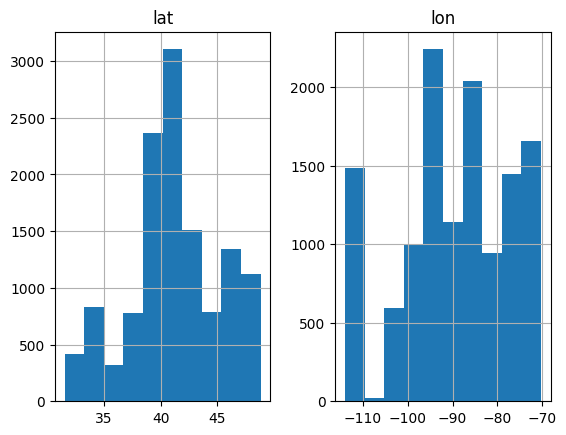

In [ ]:
df[['lat', 'lon']].hist()
plt.show()

ดรอป column เกี่ยวกับที่อยู่อาศัยที่ไม่จำเป็นและซ้ำกันออกไป

In [ ]:
# drop useless columns
df = df.drop(columns=['state2', 'stfips', 'zip', 'region', 'cntyfips', 'idnum', 'county', 'state'])

## aggegrate total time

รวม feature เกี่ยวกับเวลา ให้เป็นชาวงเวลาตั้งแต่ start ถึง stop

- เลข 0 ข้างหน้าหายไป ทำให้จำนวนหลักไม่ตรงกับคำอธิบายตัวแปร



In [ ]:
df[['startdt', 'starttm', 'stopdt', 'stoptm']].head()

,startdt,starttm,stopdt,stoptm
0,11489,2230,11689,2235
1,22688,833,22888,1010
2,32288,1000,32488,1000
3,32488,700,32688,1200
4,32288,605,32488,610


In [ ]:
df['startdt'] = df['startdt'].astype(str).apply(lambda x : '0' + x if len(x) < 6 else x)
df['stopdt'] = df['stopdt'].astype(str).apply(lambda x : '0' + x if len(x) < 6 else x)
df['starttm'] = df['starttm'].astype(str).apply(lambda x : '0' + x if len(x) < 4 else x)
df['stoptm'] = df['stoptm'].astype(str).apply(lambda x : '0' + x if len(x) < 4 else x)

df['start_dttm'] = df['startdt'] + df['starttm']
df['stop_dttm'] = df['stopdt'] + df['stoptm']

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm']].head()

,startdt,starttm,stopdt,stoptm,start_dttm,stop_dttm
0,011489,2230,011689,2235,0114892230,0116892235
1,022688,0833,022888,1010,0226880833,0228881010
2,032288,1000,032488,1000,0322881000,0324881000
3,032488,0700,032688,1200,0324880700,0326881200
4,032288,0605,032488,0610,0322880605,0324880610


In [ ]:
df['start_dttm'] = pd.to_datetime(df['start_dttm'], format='%m%d%y%H%M')
df['stop_dttm'] = pd.to_datetime(df['stop_dttm'], format='%m%d%y%H%M')

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm']].head()

,startdt,starttm,stopdt,stoptm,start_dttm,stop_dttm
0,011489,2230,011689,2235,1989-01-14 22:30:00,1989-01-16 22:35:00
1,022688,0833,022888,1010,1988-02-26 08:33:00,1988-02-28 10:10:00
2,032288,1000,032488,1000,1988-03-22 10:00:00,1988-03-24 10:00:00
3,032488,0700,032688,1200,1988-03-24 07:00:00,1988-03-26 12:00:00
4,032288,0605,032488,0610,1988-03-22 06:05:00,1988-03-24 06:10:00


In [ ]:
df['totaltm'] = abs(df['stop_dttm'] - df['start_dttm'])
df['totaltm'] = df['totaltm'].apply(lambda x : x.total_seconds()/ (60)).astype('float32')

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm','totaltm']].head()

,startdt,starttm,stopdt,stoptm,start_dttm,stop_dttm,totaltm
0,011489,2230,011689,2235,1989-01-14 22:30:00,1989-01-16 22:35:00,2885.0
1,022688,0833,022888,1010,1988-02-26 08:33:00,1988-02-28 10:10:00,2977.0
2,032288,1000,032488,1000,1988-03-22 10:00:00,1988-03-24 10:00:00,2880.0
3,032488,0700,032688,1200,1988-03-24 07:00:00,1988-03-26 12:00:00,3180.0
4,032288,0605,032488,0610,1988-03-22 06:05:00,1988-03-24 06:10:00,2885.0


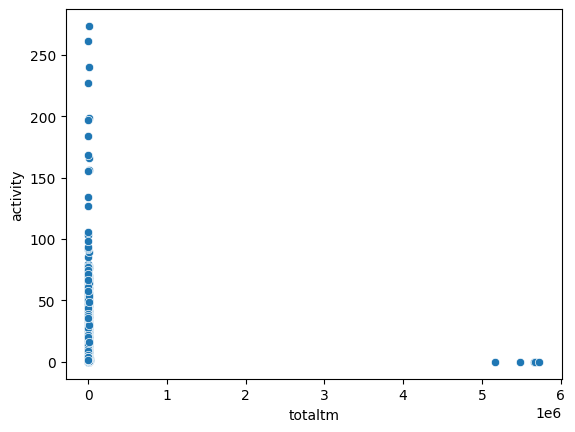

In [ ]:
sns.scatterplot(data=df, x='totaltm', y='activity')
plt.show()

ระยะเวลากับ ปริมาณ activity ไม่มีความสัมพันธ์กันชัดเจน ดังนั้น ดรอป feature เวลา ทิ้งทั้งหมด

In [ ]:
df = df.drop(columns=['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm', 'totaltm'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  12573 non-null  float32
 1   Uppm      12573 non-null  float32
 2   adjwt     12573 non-null  float32
 3   basement  12573 non-null  object 
 4   dupflag   12573 non-null  int32  
 5   floor     12573 non-null  int32  
 6   lat       12573 non-null  float32
 7   lon       12573 non-null  float32
 8   pcterr    12573 non-null  float32
 9   rep       12573 non-null  int32  
 10  room      12573 non-null  int32  
 11  stratum   12573 non-null  int32  
 12  typebldg  12573 non-null  int32  
 13  wave      12573 non-null  int32  
 14  windoor   12573 non-null  object 
 15  zipflag   12573 non-null  int32  
dtypes: float32(6), int32(8), object(2)
memory usage: 884.2+ KB


## activity(target)

ตรวจสอบค่าสถิติเบื้องต้นของ feature ตัวเลข
- rep, wave มีค่าต่ำสุด -1

In [ ]:
num_fac = df[['activity', 'Uppm', 'adjwt', 'pcterr', 'rep', 'stratum', 'wave']]
num_fac.describe()

,activity,Uppm,adjwt,pcterr,rep,stratum,wave
count,12573.000000,12573.000000,12573.000000,12573.000000,12573.000000,12573.000000,12573.000000
mean,4.460781,1.974840,549.680115,13.376051,2.776028,3.170126,55.599539
std,9.239971,0.726788,441.200043,13.274920,1.662104,3.625495,34.132766
min,0.000000,0.000000,2.081602,0.000000,-1.000000,1.000000,-1.000000
25%,1.100000,1.619770,288.889313,5.100000,2.000000,1.000000,31.000000
50%,2.200000,2.007850,443.843689,9.800000,3.000000,2.000000,53.000000
75%,4.800000,2.433430,710.826416,18.299999,4.000000,4.000000,81.000000
max,273.500000,3.767130,2364.762695,490.399994,5.000000,29.000000,140.000000


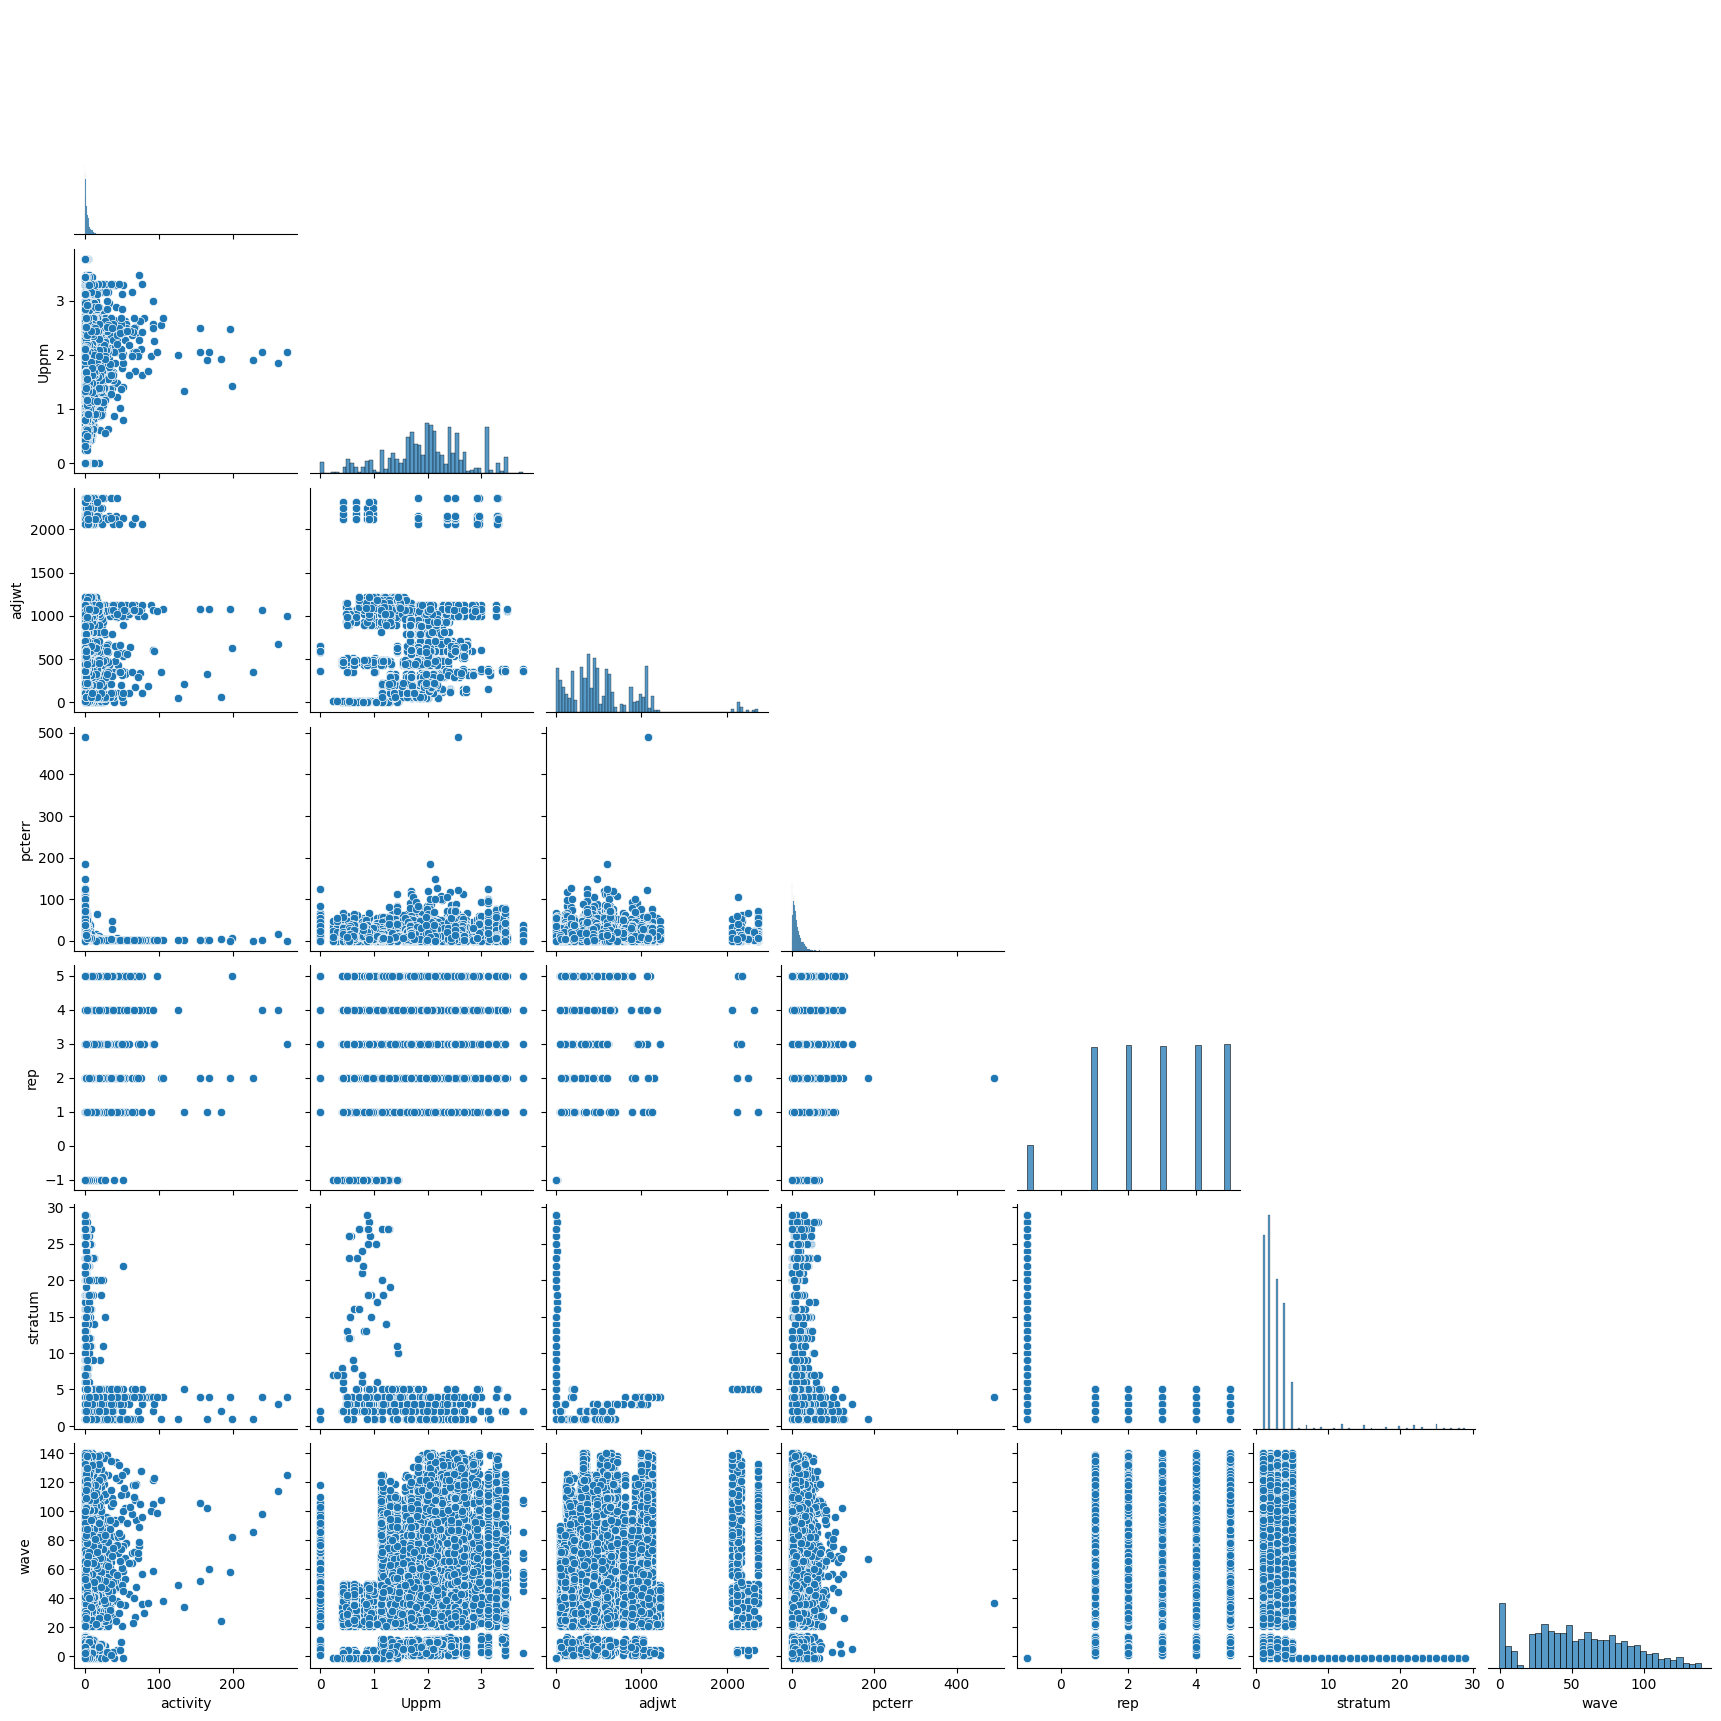

In [ ]:
sns.pairplot(num_fac, corner=True)
plt.show()

จาก scatter plot พบว่า ตัวแปรตัวเลขน่าจะส่งผลกับปริมาณ activity ได้

In [ ]:
def clean_outliers(data,column) :
    seventy_fifth = data[column].quantile(0.75)
    twenty_fifth = data[column].quantile(0.25)
    iqr = seventy_fifth - twenty_fifth
    upper = seventy_fifth + (1.5 * iqr)
    lower = twenty_fifth - (1.5 * iqr)
    data_clean = data[ (data[column] > lower) & (data[column] < upper) ]
    data_clean.reset_index(inplace = True)
    data_clean = data_clean.drop(columns=['index'])
    return data_clean

def dist_plot(data, col) :
  plt.figure(figsize=(15,3))
  plt.subplot(1,2,1)
  plt.title('Boxplot of ' + str(col))
  sns.boxplot( data=data, x=col)
  plt.subplot(1,2,2)
  plt.title('Histogram of ' + str(col))
  sns.histplot(data=data, x=col)
  plt.show()

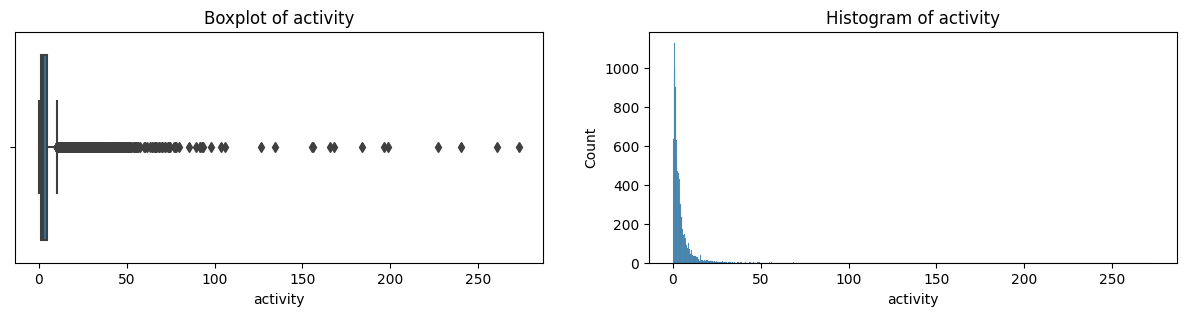

In [ ]:
dist_plot(df, 'activity')

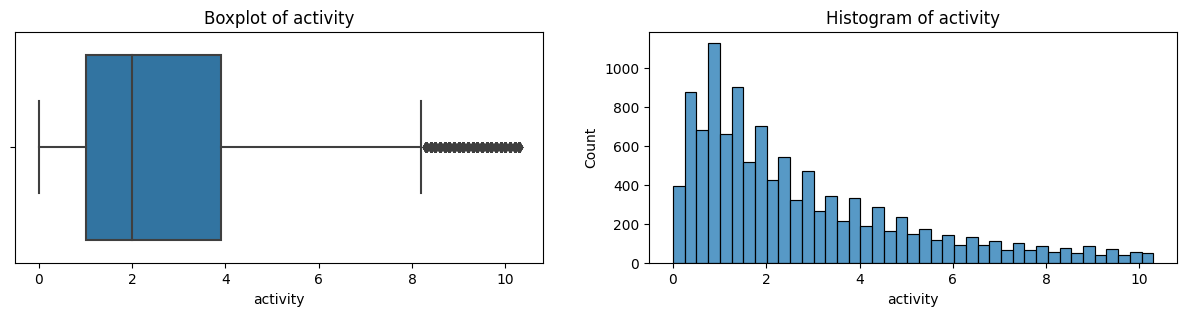

In [ ]:
df = clean_outliers(df,'activity')
dist_plot(df, 'activity')

In [ ]:
df.shape

(11505, 16)

## rep, wave

เอาค่า rep และ wave ที่เป็น -1 ออก

In [ ]:
df = df[(df['rep'] != -1) | (df['wave'] != -1)]
df.reset_index(inplace = True)
df = df.drop(columns=['index'])
df.shape

(10793, 16)

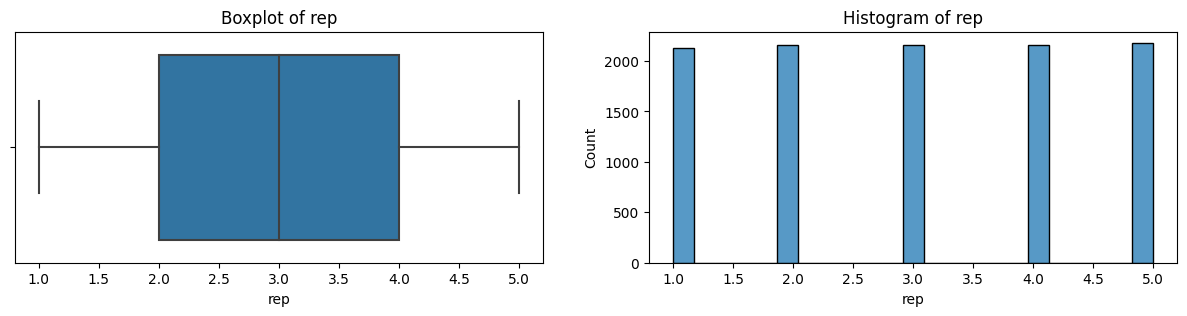

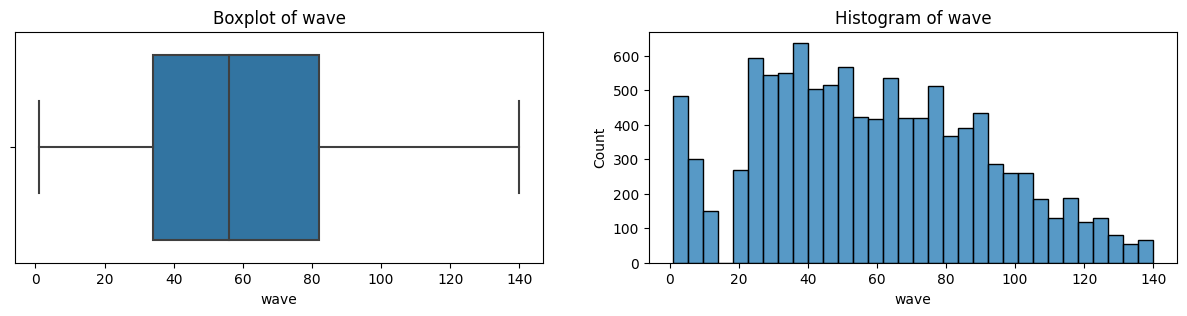

In [ ]:
dist_plot(df, 'rep')
dist_plot(df, 'wave')

## Uppm

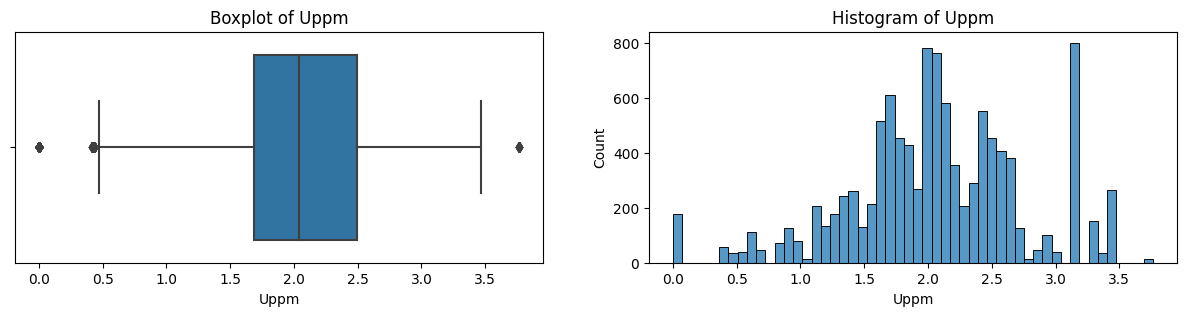

In [ ]:
dist_plot(df, 'Uppm')

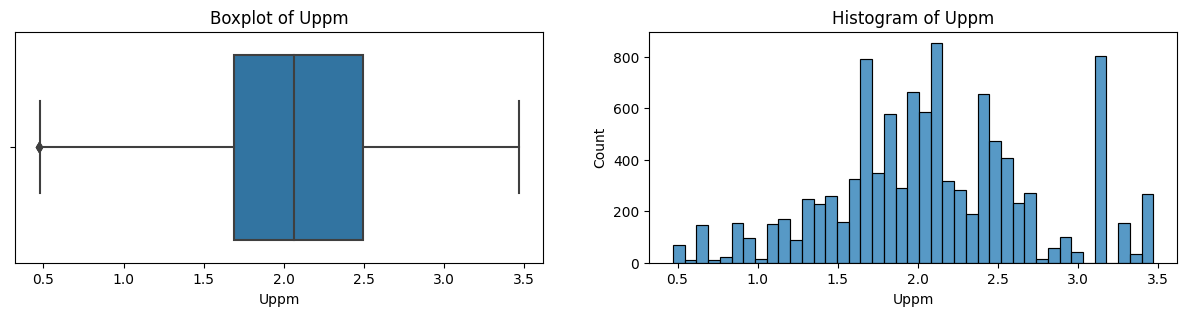

In [ ]:
df = clean_outliers(df,'Uppm')
dist_plot(df, 'Uppm')

## adjwt

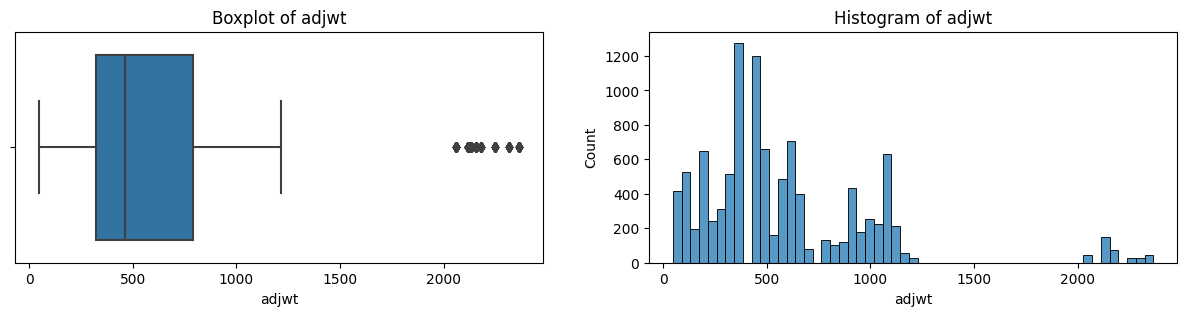

In [ ]:
dist_plot(df, 'adjwt')

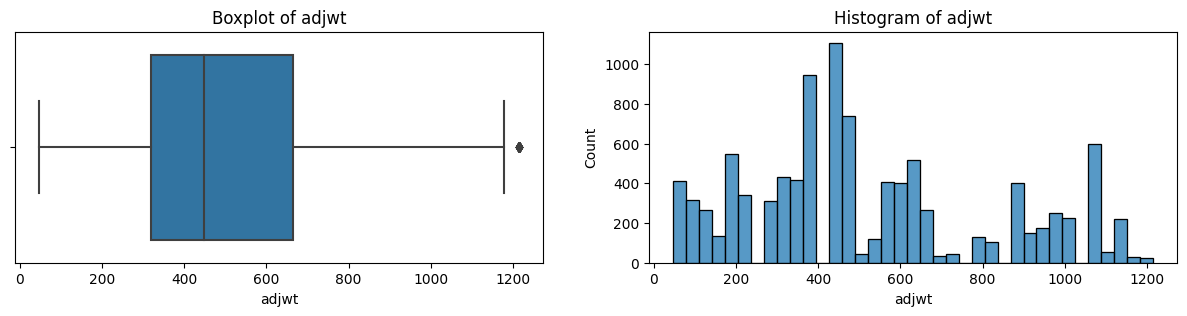

In [ ]:
df = clean_outliers(df,'adjwt')
dist_plot(df, 'adjwt')

## stratum

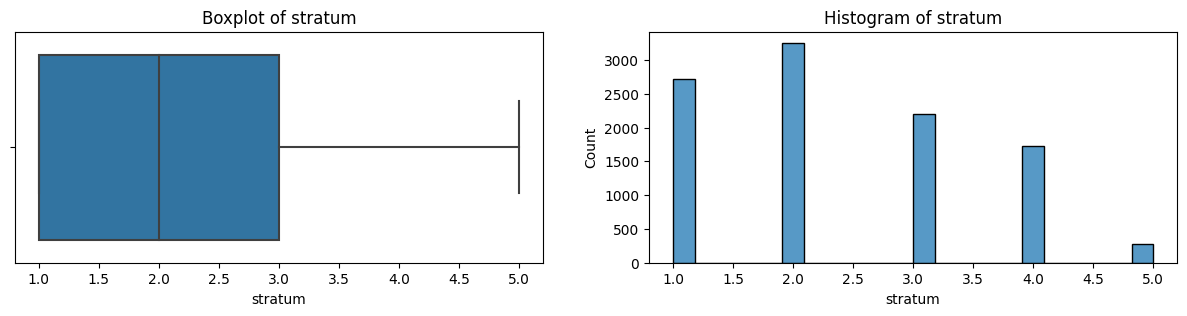

In [ ]:
dist_plot(df, 'stratum')

## pcterr

ไม่ตัด outlier ของ pcterr ออก เพราะ เป็นเป็นค่าที่สามารถบ่งชี้ถึงปริมาณ activity (true outlier)
- ทดลองเปรียนเทียบระหว่างการตัดกับไม่ตัด แล้ว กรณีไม่ตัดให้ผลการทำนายดีกว่า

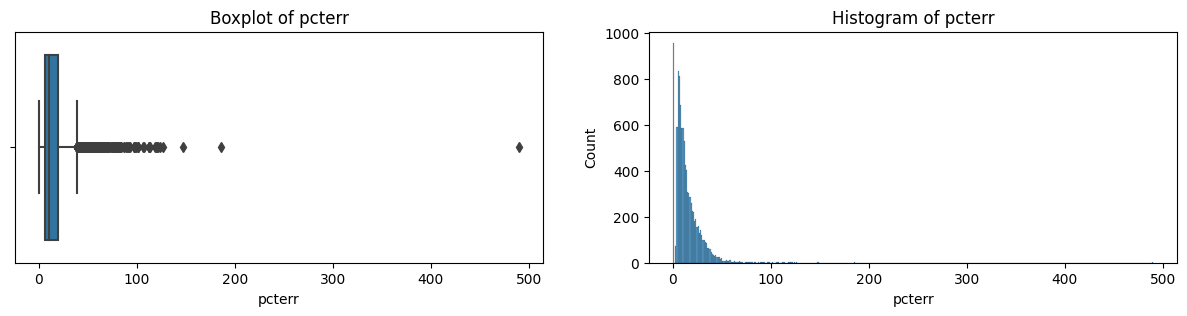

In [ ]:
dist_plot(df, 'pcterr')

## windoor

ปริมาณข้อมูลในแต่ละ category feature

In [ ]:
cate_fac = ['windoor', 'basement', 'dupflag', 'zipflag', 'room', 'floor', 'typebldg']

for col in cate_fac:
    print('column : ', col)
    print(df[col].value_counts())
    print('-'*50)

column :  windoor
b' '    10179
Name: windoor, dtype: int64
--------------------------------------------------
column :  basement
b'Y'    6576
b'N'    2961
b' '     575
b'0'      67
Name: basement, dtype: int64
--------------------------------------------------
column :  dupflag
0    9802
1     352
2      25
Name: dupflag, dtype: int64
--------------------------------------------------
column :  zipflag
0    10173
1        6
Name: zipflag, dtype: int64
--------------------------------------------------
column :  room
4    3756
2    1748
3    1477
1    1297
0    1002
7     803
5      94
6       2
Name: room, dtype: int64
--------------------------------------------------
column :  floor
0    6411
1    3477
9     253
2      20
3      18
Name: floor, dtype: int64
--------------------------------------------------
column :  typebldg
1    9147
0     532
2     361
5     131
3       8
Name: typebldg, dtype: int64
--------------------------------------------------


ดรอป windoor ทิ้ง เพราะ มีค่าเดียว

In [ ]:
df = df.drop(columns='windoor')

## basement

เปลี่ยนข้อมูลใน column basement เพื่อให้อ่านง่าย และ แทนค่า blank ด้วย U หรือ Unknow

In [ ]:
# df['basement'] = df['basement'].astype(str).str.replace('b\'0\'', 'b\'N\'', regex=True)
df['basement'] = df['basement'].astype(str).str.replace('b\' \'', 'b\'U\'', regex=True)
df['basement'] = df['basement'].astype(str).str.extract(r'b\'(\w+)\'')

df['basement'].value_counts()

Y    6576
N    2961
U     575
0      67
Name: basement, dtype: int64

เนื่องจาก 0 ไม่มีอยู่ในคำอธิบายตัวแปร จึงทำการแทนค่า ด้วยการเทียบกับตัวแปร floor

- ถ้า floor = 0 ให้แทนด้วย Y
- ถ้า floor = 9 ให้แทนด้วย U
- ถ้า floor != 0,9 ให้แทนด้วย N

In [ ]:
df[['basement' , 'floor']].value_counts()

basement  floor
Y         0        6085
N         1        2876
Y         1         471
U         0         238
          9         211
          1         121
N         0          60
0         9          30
          0          28
N         3          11
          2          10
0         1           9
Y         2           9
          9           8
U         3           4
N         9           4
Y         3           3
U         2           1
dtype: int64

In [ ]:
for row in range(len(df)):
  if df.loc[row, 'basement'] == '0' and df.loc[row, 'floor'] == 0 :
    df.loc[row, 'basement'] = 'Y'
  elif df.loc[row, 'basement'] == '0' and df.loc[row, 'floor'] == 9 :
    df.loc[row, 'basement'] = 'U'
  elif df.loc[row, 'basement'] == '0' and df.loc[row, 'floor'] == 1 :
    df.loc[row, 'basement'] = 'N'

[]

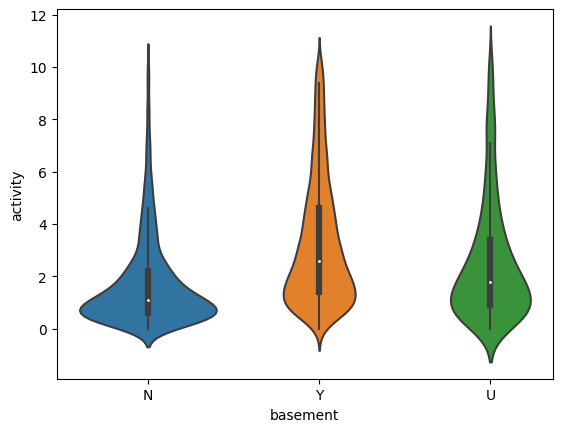

In [ ]:
sns.violinplot(data=df, x='basement', y='activity')
plt.plot()

## dupflag

In [ ]:
df['dupflag'].value_counts()

0    9802
1     352
2      25
Name: dupflag, dtype: int64

เนื่องจาก dupflag มีค่าเป็น 0 หรือ 1
- แทนค่า 2 ด้วย 1

In [ ]:
df['dupflag'].replace(2, 1, inplace=True)
df['dupflag'].value_counts()

0    9802
1     377
Name: dupflag, dtype: int64

[]

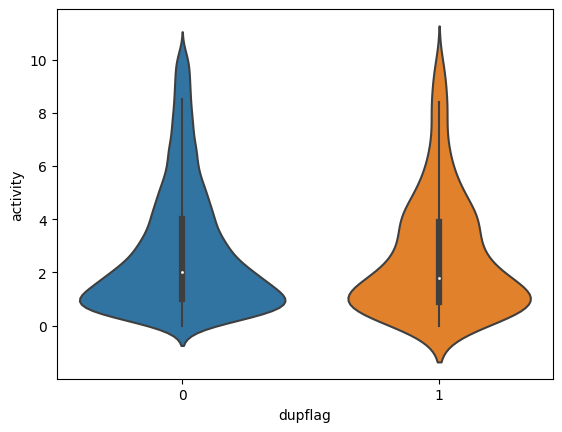

In [ ]:
sns.violinplot(data=df, x='dupflag', y='activity')
plt.plot()

## zipflag

พบว่า zipflag มีข้อมูลในส่วนของค่า 1 น้อยมาก จึงไม่ใช้ feature นี้ในการสร้างโมเดล

In [ ]:
df['zipflag'].value_counts()

0    10173
1        6
Name: zipflag, dtype: int64

In [ ]:
df = df.drop(columns='zipflag')

## room

In [ ]:
df['room'].value_counts()

4    3756
2    1748
3    1477
1    1297
0    1002
7     803
5      94
6       2
Name: room, dtype: int64

[]

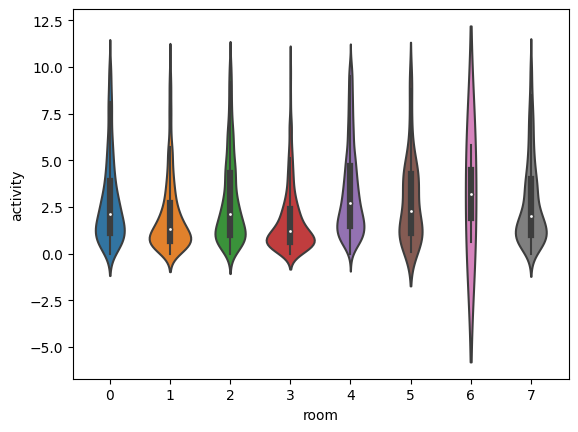

In [ ]:
sns.violinplot(data=df, x='room', y='activity')
plt.plot()

## floor

In [ ]:
df['floor'].value_counts()

0    6411
1    3477
9     253
2      20
3      18
Name: floor, dtype: int64

floor = 3 เป็นค่าผิดปกติจึงทำการรวมกับ 2 เพราะ ในคำอธิบายใช้เลข 2 แทน ค่าตั้งแต่ 2 ขึ้นไป

In [ ]:
df['floor'].replace(3, 2, inplace=True)
df['floor'].value_counts()

0    6411
1    3477
9     253
2      38
Name: floor, dtype: int64

[]

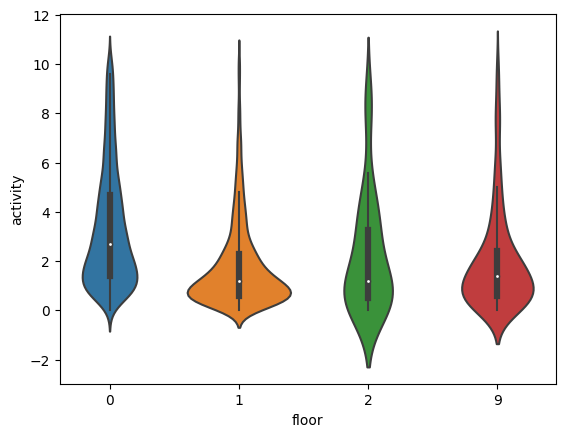

In [ ]:
sns.violinplot(data=df, x='floor', y='activity')
plt.plot()

## typebldg

In [ ]:
df['typebldg'].value_counts()

1    9147
0     532
2     361
5     131
3       8
Name: typebldg, dtype: int64

[]

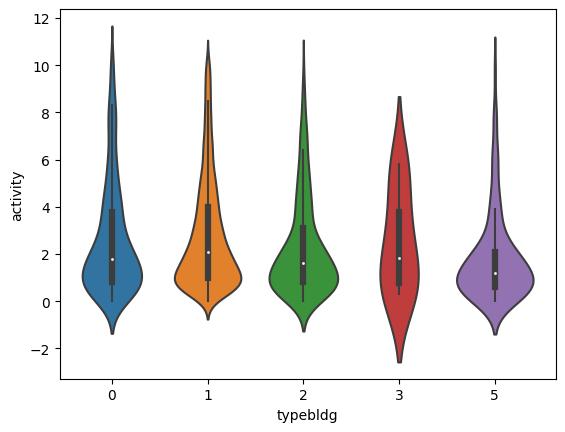

In [ ]:
sns.violinplot(data=df, x='typebldg', y='activity')
plt.plot()

แปลง column ที่เป็น category ทั้งหมดให้เป็น str

In [ ]:
cate_fac = ['typebldg', 'floor', 'room', 'basement', 'dupflag']
for col in cate_fac:
  df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10179 entries, 0 to 10178
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  10179 non-null  float32
 1   Uppm      10179 non-null  float32
 2   adjwt     10179 non-null  float32
 3   basement  10179 non-null  object 
 4   dupflag   10179 non-null  object 
 5   floor     10179 non-null  object 
 6   lat       10179 non-null  float32
 7   lon       10179 non-null  float32
 8   pcterr    10179 non-null  float32
 9   rep       10179 non-null  int32  
 10  room      10179 non-null  object 
 11  stratum   10179 non-null  int32  
 12  typebldg  10179 non-null  object 
 13  wave      10179 non-null  int32  
dtypes: float32(6), int32(3), object(5)
memory usage: 755.6+ KB


In [ ]:
df.head()

,activity,Uppm,adjwt,basement,dupflag,floor,lat,lon,pcterr,rep,room,stratum,typebldg,wave
0,1.6,2.49759,292.219543,N,0,1,41.091000,-85.067001,12.7,3,2,2,1,92
1,0.5,2.66527,364.958313,N,0,1,34.599998,-112.554001,0.0,5,2,2,1,56
2,3.0,2.43343,626.564575,Y,0,0,42.485001,-71.391998,9.7,1,2,1,1,23
3,0.6,2.43343,570.611755,N,0,1,42.485001,-71.391998,27.6,3,3,1,1,62
4,1.2,2.10811,426.798859,Y,0,0,39.007999,-94.347000,23.5,3,4,2,1,91


# Splitting data

In [ ]:
x = pd.get_dummies(df).drop(columns=['activity'])
y = df['activity']

print('shape of x = ', x.shape)
print('shape of y = ' , y.shape)

shape of x =  (10179, 30)
shape of y =  (10179,)


In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10179 entries, 0 to 10178
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Uppm        10179 non-null  float32
 1   adjwt       10179 non-null  float32
 2   lat         10179 non-null  float32
 3   lon         10179 non-null  float32
 4   pcterr      10179 non-null  float32
 5   rep         10179 non-null  int32  
 6   stratum     10179 non-null  int32  
 7   wave        10179 non-null  int32  
 8   basement_N  10179 non-null  uint8  
 9   basement_U  10179 non-null  uint8  
 10  basement_Y  10179 non-null  uint8  
 11  dupflag_0   10179 non-null  uint8  
 12  dupflag_1   10179 non-null  uint8  
 13  floor_0     10179 non-null  uint8  
 14  floor_1     10179 non-null  uint8  
 15  floor_2     10179 non-null  uint8  
 16  floor_9     10179 non-null  uint8  
 17  room_0      10179 non-null  uint8  
 18  room_1      10179 non-null  uint8  
 19  room_2      10179 non-nul

In [ ]:
# train (7,000 ตัว), validation (3,000 ตัว) และ test set (ข้อมูลที่เหลือ)
x_temp, x_train, y_temp, y_train = train_test_split(x, y, test_size=7000/x.shape[0], random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=3000/x_temp.shape[0], random_state=44)

print('training set = {:.2f} rows'.format(x_train.shape[0]))
print('validation set = {:.2f} rows'.format(x_valid.shape[0]))
print('test set = {:.2f} rows'.format(x_test.shape[0]))

training set = 7000.00 rows
validation set = 3000.00 rows
test set = 179.00 rows


# Data Modeling

scale input feature ก่อน เพื่อให้โมเดลสามารถลู่หาค่า activity ที่มีการกระจายเบ้ขวาได้ดีขึ้น เลือก StandardScaler เพราะ การกระจาย input ค่อนข้าง normal

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

## manual model

 train โมเดลโดยการสุ่มมือเพื่อ ดูลักษณะ architecture

In [ ]:
def manual():
  model = Sequential()
  model.add(Input(shape=(x.shape[1],)))
  model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), loss='mean_absolute_error', metrics=['mae'])
  return model

model = manual()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,
                                              min_delta = 0.001, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_split=0.3, epochs=150, batch_size=512, callbacks=[early_stop])

Epoch 1/150
10/10 [==============================] - 1s 31ms/step - loss: 1.9277 - mae: 1.9277 - val_loss: 1.5741 - val_mae: 1.5741
Epoch 2/150
10/10 [==============================] - 0s 6ms/step - loss: 1.4462 - mae: 1.4462 - val_loss: 1.4434 - val_mae: 1.4434
Epoch 3/150
10/10 [==============================] - 0s 7ms/step - loss: 1.3198 - mae: 1.3198 - val_loss: 1.3562 - val_mae: 1.3562
Epoch 4/150
10/10 [==============================] - 0s 8ms/step - loss: 1.2437 - mae: 1.2437 - val_loss: 1.2847 - val_mae: 1.2847
Epoch 5/150
10/10 [==============================] - 0s 7ms/step - loss: 1.1863 - mae: 1.1863 - val_loss: 1.2416 - val_mae: 1.2416
Epoch 6/150
10/10 [==============================] - 0s 6ms/step - loss: 1.1529 - mae: 1.1529 - val_loss: 1.2076 - val_mae: 1.2076
Epoch 7/150
10/10 [==============================] - 0s 7ms/step - loss: 1.1258 - mae: 1.1258 - val_loss: 1.1691 - val_mae: 1.1691
Epoch 8/150
10/10 [==============================] - 0s 10ms/step - loss: 1.1044 -

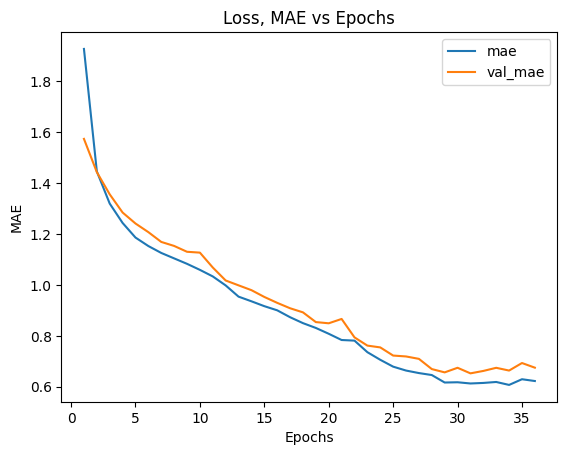

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['mae'], label = 'mae')
plt.plot(epochs, history.history['val_mae'], label = 'val_mae')
plt.title('Loss, MAE vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
loss, mae = model.evaluate(x_train, y_train)
print('train mae = ', mae)

219/219 [==============================] - 1s 2ms/step - loss: 0.6096 - mae: 0.6096
train mae =  0.6096399426460266


In [ ]:
loss, mae = model.evaluate(x_valid, y_valid)
print('valid mae = ', mae)

94/94 [==============================] - 0s 3ms/step - loss: 0.6445 - mae: 0.6445
valid mae =  0.6444807648658752


In [ ]:
loss, mae = model.evaluate(x_test, y_test)
print('test mae = ', mae)

6/6 [==============================] - 0s 3ms/step - loss: 0.5734 - mae: 0.5734
test mae =  0.5734484791755676


In [ ]:
print('True value of first item : {:.2f}'.format(y_test.iloc[0]))
print('Predict value of first item : {:.2f}'.format(model.predict(x_test, verbose=0)[0][0]))

True value of first item : 2.90
Predict value of first item : 2.51


## Hyperband

หา best model ที่มีการทำ dropout

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(x.shape[1],)))
    if hp.Boolean("batchnorm"):
      model.add(BatchNormalization())
    for i in range(hp.Int("num_layers", min_value=1, max_value=8)):
      model.add(Dense(units=hp.Int("units_" + str(i), min_value=10, max_value=2*x.shape[1], step=1),
                      activation=hp.Choice("activation", values=['relu', 'elu', 'selu'])))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='mean_absolute_error',
                  metrics=['mae'])
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_mae",
                     max_epochs=81,
                     factor=3,
                     directory="kt_dir1",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
batchnorm (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,
                                              min_delta = 0.001, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=81, validation_data=(x_valid,y_valid),
             batch_size=512, callbacks=[early_stop], verbose=2)

Trial 211 Complete [00h 00m 22s]
val_mae: 1.4193408489227295

Best val_mae So Far: 0.580994188785553
Total elapsed time: 00h 16m 00s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps.get('units_0'))
print(best_hps.get('units_1'))
print(best_hps.get('units_2'))
print(best_hps.get('units_3'))
print(best_hps.get('units_4'))
print(best_hps.get('lr'))
print(best_hps.get('batchnorm'))
print(best_hps.get('num_layers'))
print(best_hps.get('activation'))
print(best_hps.get('dropout_0'))
print(best_hps.get('dropout_1'))
print(best_hps.get('dropout_2'))
print(best_hps.get('dropout_3'))
print(best_hps.get('dropout_4'))

36
20
42
34
57
0.009339162607282521
True
5
elu
0.30000000000000004
0.4
0.2
0.4
0.1


In [ ]:
best_model = tuner.get_best_models()[0]
print(best_model.evaluate(x_test, y_test))

6/6 [==============================] - 0s 4ms/step - loss: 0.5526 - mae: 0.5526
[0.5525959134101868, 0.5525959134101868]


In [ ]:
print('True value of first item : {:.2f}'.format(y_test.iloc[0]))
print('Predict value of first item : {:.2f}'.format(best_model.predict(x_test, verbose=0)[0][0]))

True value of first item : 2.90
Predict value of first item : 1.87


## Hyperband before

หา best model ที่มีการทำ dropout และ BatchNormalization ที่ z

In [ ]:
def build_model_before(hp):
    model = Sequential()
    model.add(Input(shape=(x.shape[1],)))
    if hp.Boolean("batchnorm"):
      model.add(BatchNormalization())
    for i in range(hp.Int("num_layers", min_value=1, max_value=8)):
      model.add(Dense(units=hp.Int("units_" + str(i), min_value=10, max_value=2*x.shape[1], step=1)))
      model.add(BatchNormalization())
      model.add(Activation(hp.Choice("activation", values=['relu', 'elu', 'selu'])))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='mean_absolute_error',
                  metrics=['mae'])
    return model

In [ ]:
# Instantiate the tuner
tuner_b = kt.Hyperband(build_model_before,
                     objective="val_mae",
                     max_epochs=81,
                     factor=3,
                     directory="kt_dir2",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner_b.search_space_summary()

Search space summary
Default search space size: 6
batchnorm (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,
                                              min_delta = 0.001, restore_best_weights=True)

tuner_b.search(x_train, y_train, epochs=81, validation_data=(x_valid,y_valid),
             batch_size=512, callbacks=[early_stop], verbose=2)

Trial 211 Complete [00h 00m 48s]
val_mae: 1.5435858964920044

Best val_mae So Far: 0.5984727144241333
Total elapsed time: 00h 24m 01s


In [ ]:
best_before_hps=tuner_b.get_best_hyperparameters()[0]
print(best_before_hps.get('units_0'))
print(best_before_hps.get('units_1'))
print(best_before_hps.get('units_2'))
print(best_before_hps.get('lr'))
print(best_before_hps.get('batchnorm'))
print(best_before_hps.get('num_layers'))
print(best_before_hps.get('activation'))
print(best_before_hps.get('dropout_0'))
print(best_before_hps.get('dropout_1'))
print(best_before_hps.get('dropout_2'))

41
45
49
0.004910100840508796
False
3
relu
0.1
0.1
0.0


In [ ]:
best_before_model = tuner_b.get_best_models()[0]
print(best_before_model.evaluate(x_test, y_test))

6/6 [==============================] - 0s 4ms/step - loss: 0.5396 - mae: 0.5396
[0.5395644307136536, 0.5395644307136536]


In [ ]:
print('True value of first item : {:.2f}'.format(y_test.iloc[0]))
print('Predict value of first item : {:.2f}'.format(best_before_model.predict(x_test, verbose=0)[0][0]))

True value of first item : 2.90
Predict value of first item : 2.69


## Hyperband after

หา best model ที่มีการทำ dropout และ BatchNormalization ที่ a

In [ ]:
def build_model_after(hp):
    model = Sequential()
    model.add(Input(shape=(x.shape[1],)))
    if hp.Boolean("batchnorm"):
      model.add(BatchNormalization())
    for i in range(hp.Int("num_layers", min_value=1, max_value=8)):
      model.add(Dense(units=hp.Int("units_" + str(i), min_value=10, max_value=2*x.shape[1], step=1),
                      activation=hp.Choice("activation", values=['relu', 'elu', 'selu'])))
      model.add(BatchNormalization())
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='mean_absolute_error',
                  metrics=['mae'])
    return model

In [ ]:
# Instantiate the tuner
tuner_a = kt.Hyperband(build_model_after,
                     objective="val_mae",
                     max_epochs=81,
                     factor=3,
                     directory="kt_dir5",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner_a.search_space_summary()

Search space summary
Default search space size: 6
batchnorm (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,
                                              min_delta = 0.001, restore_best_weights=True)

tuner_a.search(x_train, y_train, epochs=81, validation_data=(x_valid,y_valid),
             batch_size=512, callbacks=[early_stop], verbose=2)

Trial 211 Complete [00h 00m 43s]
val_mae: 1.749662160873413

Best val_mae So Far: 0.6059672236442566
Total elapsed time: 00h 25m 01s


In [ ]:
best_after_hps=tuner_a.get_best_hyperparameters()[0]
print(best_after_hps.get('units_0'))
print(best_after_hps.get('units_1'))
print(best_after_hps.get('units_2'))
print(best_after_hps.get('lr'))
print(best_after_hps.get('batchnorm'))
print(best_after_hps.get('num_layers'))
print(best_after_hps.get('activation'))
print(best_after_hps.get('dropout_0'))
print(best_after_hps.get('dropout_1'))
print(best_after_hps.get('dropout_2'))

52
48
15
0.00976844384018483
False
2
relu
0.1
0.2
0.4


In [ ]:
best_after_model = tuner_a.get_best_models()[0]
print(best_after_model.evaluate(x_test, y_test))

6/6 [==============================] - 0s 4ms/step - loss: 0.5522 - mae: 0.5522
[0.5522361397743225, 0.5522361397743225]


In [ ]:
print('True value of first item : {:.2f}'.format(y_test.iloc[0]))
print('Predict value of first item : {:.2f}'.format(best_after_model.predict(x_test, verbose=0)[0][0]))

True value of first item : 2.90
Predict value of first item : 1.73


# Evaluate & Improve

**ข้อสังเกต :** เนื่องจาก test set (179 row) ที่เหลืออยู่มีขนาดเล็กกว่า validation set (3000 row) มาก ทำให้ผลการคำนวณ mae ที่ออกมาจึงมีค่าต่ำกว่าการทดสอบกับ train และ valid แต่ก็ยังแตกต่างไม่มากนัก(ทศนิยมหลักที่ 2)

ดังนั้น เลือกโมเดลในหัวข้อ Hyyperband before เพราะ มี mae ในการทดสอบกับ test set น้อยที่สุด ซึ่งมีโครงสร้าง ดังนี้
1. input layer มี 30 node
2. hidden layer 3 ชั้น จำนวน node คือ 41, 45, 49 ตามลำดับ
<p> -  ทำ BatchNormalize ก่อนเข้า activation
<p> -  ใช้ activation function เป็น relu
<p> -  Drop out rate คือ 0.1, 0.1, 0 ตามลำดับ
<p> -  Optimizer ด้วย Adam, Lr ประมาณ 0.005
3. output layer มี 1 node ใช้ linear เป็น activation







In [ ]:
best_before_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1271      
                                                                 
 batch_normalization (BatchN  (None, 41)               164       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 41)                0         
                                                                 
 dropout (Dropout)           (None, 41)                0         
                                                                 
 dense_1 (Dense)             (None, 45)                1890      
                                                                 
 batch_normalization_1 (Batc  (None, 45)               180       
 hNormalization)                                        

In [ ]:
pred = pd.DataFrame()
pred['y_test'] = y_test
pred['y_pred'] = best_before_model.predict(x_test, verbose = 0)
pred.head(10)

,y_test,y_pred
6445,2.9,2.687193
2745,0.4,0.424341
7394,5.0,5.741333
629,2.1,2.434095
9007,0.7,0.624778
8286,2.7,1.729827
7490,6.1,5.298713
8198,8.1,4.736244
2056,0.8,1.012333
9001,3.2,3.106730
